# Escuela de Ciencia de Datos 2020

## Predicción de mortalidad hospitalaria en pacientes con SARS-COV-2 basado en aprendizaje máquina

## Objectivo:
A partir de los datos disponibles por la [Secretaría de Salud](https://datos.gob.mx/busca/dataset/informacion-referente-a-casos-covid-19-en-mexico), se construirá un modelo que permita estimar el riesgo de mortalidad en pacientes con SARS-COV 2 y se identificaran las variables clínicas que incrementan la mortalidad en los pacientes.

## Retos en el procesamiento de Registros clínicos electrónicos EHR
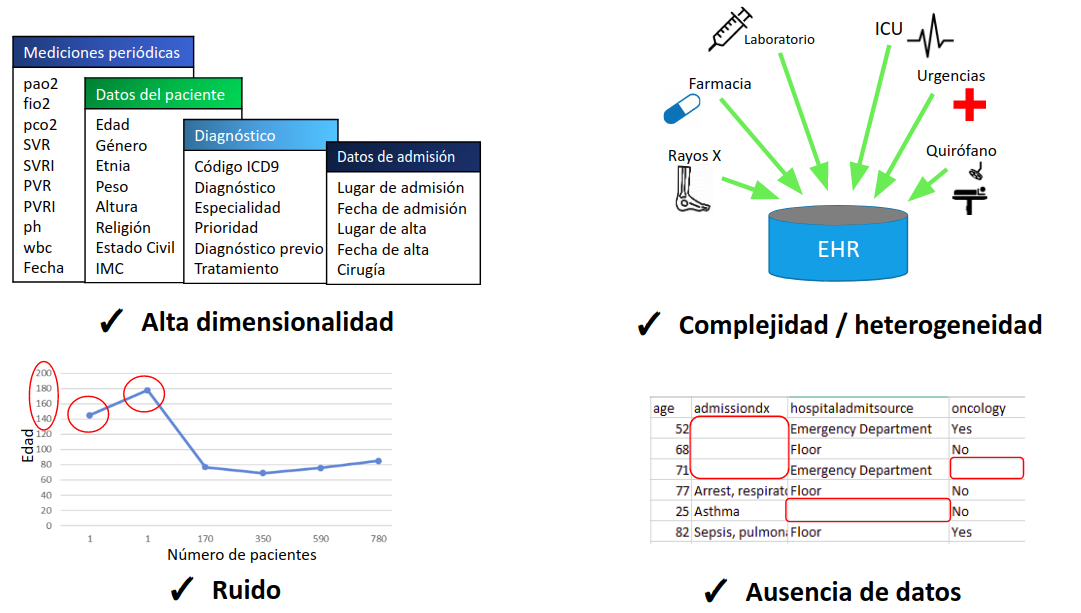

## Carga de datos

In [1]:
"""Añadimos las bibliotecas necesarias para la construcción del modelo"""
import argparse
import shap
shap.initjs()
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from sklearn.utils.class_weight import compute_sample_weight
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV,RepeatedStratifiedKFold
from sklearn.metrics import roc_curve, auc, roc_auc_score, classification_report, confusion_matrix, accuracy_score, f1_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import os
import sys
import warnings
warnings.filterwarnings('ignore')

In [2]:
def read_data(raw_clinical_note):
    """ Read clinical data """
    data = pd.read_csv(raw_clinical_note, header=0,na_filter=True)
    return data

print("Loading data")
raw_data = '../data/201018COVID19MEXICO.csv'
data = pd.read_csv(raw_data, encoding= 'latin-1')
print("Total de registros:", data.shape[0])

Loading data
Total de registros: 2183272


In [3]:
print("Listado de variables: \n",data.columns)

Listado de variables: 
 Index(['FECHA_ACTUALIZACION', 'ID_REGISTRO', 'ORIGEN', 'SECTOR', 'ENTIDAD_UM',
       'SEXO', 'ENTIDAD_NAC', 'ENTIDAD_RES', 'MUNICIPIO_RES', 'TIPO_PACIENTE',
       'FECHA_INGRESO', 'FECHA_SINTOMAS', 'FECHA_DEF', 'INTUBADO', 'NEUMONIA',
       'EDAD', 'NACIONALIDAD', 'EMBARAZO', 'HABLA_LENGUA_INDIG', 'INDIGENA',
       'DIABETES', 'EPOC', 'ASMA', 'INMUSUPR', 'HIPERTENSION', 'OTRA_COM',
       'CARDIOVASCULAR', 'OBESIDAD', 'RENAL_CRONICA', 'TABAQUISMO',
       'OTRO_CASO', 'TOMA_MUESTRA', 'RESULTADO_LAB', 'CLASIFICACION_FINAL',
       'MIGRANTE', 'PAIS_NACIONALIDAD', 'PAIS_ORIGEN', 'UCI'],
      dtype='object')


## Análisis exploratorio de los datos

### Datos demográficos

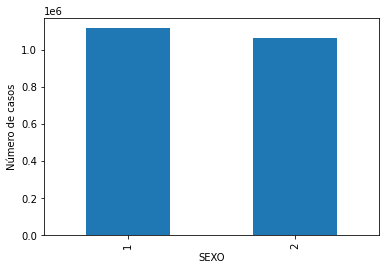

In [4]:
cpdel = data['SEXO'].value_counts().plot(kind='bar') #'1'= mujer, '2'= hombre
plt.xlabel('SEXO')
plt.ylabel('Número de casos')
plt.show()

(array([6.48810e+04, 1.97716e+05, 6.06723e+05, 5.59320e+05, 4.23832e+05,
        2.14973e+05, 9.10690e+04, 2.33160e+04, 1.35300e+03, 8.90000e+01]),
 array([  0.,  12.,  24.,  36.,  48.,  60.,  72.,  84.,  96., 108., 120.]),
 <BarContainer object of 10 artists>)

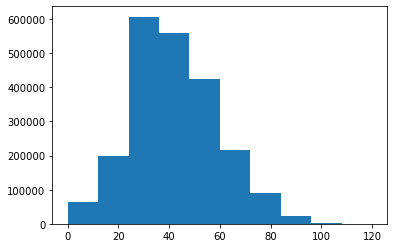

In [5]:
plt.hist(data.EDAD)

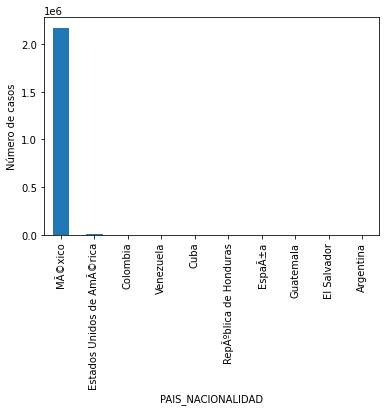

In [6]:
cpdel = data['PAIS_NACIONALIDAD'].value_counts()[:10].plot(kind='bar')
plt.xlabel('PAIS_NACIONALIDAD')
plt.ylabel('Número de casos')
plt.show()

### Comorbilidades

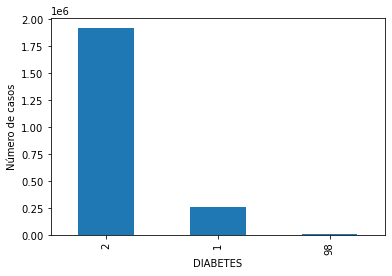

In [7]:
cpdel = data['DIABETES'].value_counts().plot(kind='bar')
plt.xlabel('DIABETES')
plt.ylabel('Número de casos')
plt.show()

In [8]:
data_comorbilidad = data[(data.DIABETES==1) 
                        |(data.HIPERTENSION==1)
                        |(data.OBESIDAD==1)]
print("Total de pacientes con alguna comorbilidad común: ", data_comorbilidad.shape[0])

Total de pacientes con alguna comorbilidad común:  659766


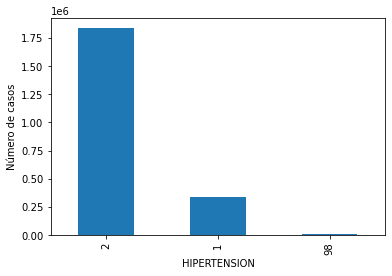

In [9]:
cpdel = data['HIPERTENSION'].value_counts().plot(kind='bar')
plt.xlabel('HIPERTENSION')
plt.ylabel('Número de casos')
plt.show()

### Datos hospitalarios

Identifica si el paciente es un caso de COVID-19 según el catálogo "CLASIFICACION_FINAL".

- '1' = CASO DE COVID-19 CONFIRMADO POR ASOCIACIÓN CLÍNICA EPIDEMIOLÓGICA
- '2' = CASO DE COVID-19 CONFIRMADO POR COMITÉ DE  DICTAMINACIÓN
- '3' = CASO DE SARS-COV-2  CONFIRMADO POR LABORATORIO
- '4' = INVÁLIDO POR LABORATORIO
- '5' = NO REALIZADO POR LABORATORIO
- '6' = CASO SOSPECHOSO
- '7' = NEGATIVO A SARS-COV-2 POR LABORATORIO

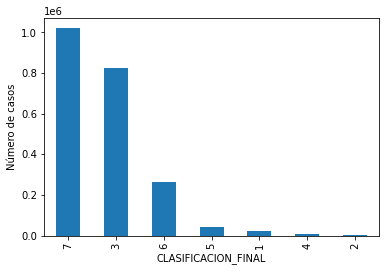

7    1019821
3     826576
6     265492
5      40954
1      24032
4       5778
2        619
Name: CLASIFICACION_FINAL, dtype: int64


In [11]:
cpdel = data['CLASIFICACION_FINAL'].value_counts().plot(kind='bar')
plt.xlabel('CLASIFICACION_FINAL')
plt.ylabel('Número de casos')
plt.show()
print(data['CLASIFICACION_FINAL'].value_counts()) #usaremos el código: 1-3 para indicar positivos a SARS-COV2

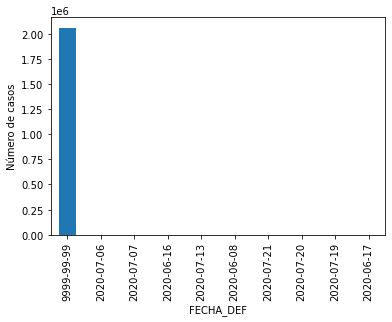

9999-99-99    2059923
2020-07-06        980
2020-07-07        966
2020-06-16        956
2020-07-13        948
               ...   
2020-03-08          5
2020-01-06          3
2020-01-05          2
2020-01-04          1
2020-01-02          1
Name: FECHA_DEF, Length: 291, dtype: int64


In [12]:
cpdel = data['FECHA_DEF'].value_counts()[:10].plot(kind='bar')
plt.xlabel('FECHA_DEF')
plt.ylabel('Número de casos')
plt.show()
print(data['FECHA_DEF'].value_counts())

## Pre-procesamiento de los datos

In [13]:
""" 1. Reemplazo de los elementos nulos por 0 """
data_pre = data.fillna(0)

In [14]:
""" 2. Cálculo del no. días transcurridos entre FECHA_SINTOMAS ---> FECHA_INGRESO"""
def dias_transcurridos(data):
    """Calculamos el tiempo que pasó desde que presentó síntomas hasta que ingresó al hospital"""
    data['FECHA_SINTOMAS']= pd.to_datetime(data['FECHA_SINTOMAS'])
    data['FECHA_INGRESO']= pd.to_datetime(data['FECHA_INGRESO'])
    data['ND_TRANSCURRIDOS']= data['FECHA_INGRESO'] - data['FECHA_SINTOMAS']
    data['ND_TRANSCURRIDOS'] = data['ND_TRANSCURRIDOS'] / np.timedelta64(1, 'D')
    return data

data_pre = dias_transcurridos(data_pre)

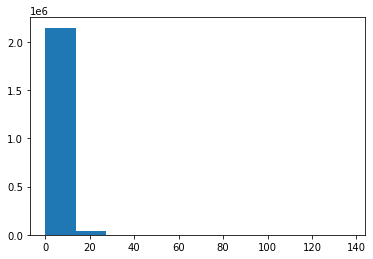

In [15]:
plt.hist(data_pre.ND_TRANSCURRIDOS);

In [16]:
"""3.- Añadir columnas para selección de pacientes"""
def addcols(data):
    data['PAT_COVID'] = np.where((data['CLASIFICACION_FINAL'] == 1) |
                                (data['CLASIFICACION_FINAL'] == 2) |
                                (data['CLASIFICACION_FINAL'] == 3), '1', '0').astype(int)
    data['PAT_FAC'] = np.where(data['FECHA_DEF'] != '9999-99-99', '1', '0').astype(int)
    return data

data_pre = addcols(data_pre)

In [17]:
"""4. One-hot encoding"""
def encoding(data):
    data['INTUBADO'] = np.where(data['INTUBADO'] == 1, 1, '0').astype(int)
    data['NEUMONIA'] = np.where(data['NEUMONIA'] == 1, 1, '0').astype(int)
    data['EMBARAZO'] = np.where(data['EMBARAZO'] == 1, 1, '0').astype(int)
    data['INDIGENA'] = np.where(data['INDIGENA'] == 1, 1, '0').astype(int)
    data['DIABETES'] = np.where(data['DIABETES'] == 1, 1, '0').astype(int)
    data['EPOC'] = np.where(data['EPOC'] == 1, 1, '0').astype(int)
    data['ASMA'] = np.where(data['ASMA'] == 1, 1, '0').astype(int)
    data['INMUSUPR'] = np.where(data['INMUSUPR'] == 1, 1, '0').astype(int)
    data['HIPERTENSION'] = np.where(data['HIPERTENSION'] == 1, 1, '0').astype(int)
    data['OTRA_COM'] = np.where(data['OTRA_COM'] == 1, 1, '0').astype(int)
    data['CARDIOVASCULAR'] = np.where(data['CARDIOVASCULAR'] == 1, 1, '0').astype(int)
    data['OBESIDAD'] = np.where(data['OBESIDAD'] == 1, 1, '0').astype(int)
    data['RENAL_CRONICA'] = np.where(data['RENAL_CRONICA'] == 1, 1, '0').astype(int)
    data['TABAQUISMO'] = np.where(data['TABAQUISMO'] == 1, 1, '0').astype(int)
    data['UCI'] = np.where(data['UCI'] == 1, 1, '0').astype(int)
    data['OTRA_COM'] = np.where(data['OTRA_COM'] == 1, 1, '0').astype(int)
    data['TIPO_PACIENTE'] = np.where(data['TIPO_PACIENTE'] == 1, 1, '0').astype(int)
    
    #entidades
    data['AGUASCALIENTES'] = np.where(data['ENTIDAD_UM'] == 1, '1', '0').astype(int)
    data['BAJA_CALIFORNIA'] = np.where(data['ENTIDAD_UM'] == 2, '1', '0').astype(int)
    data['BAJA_CALIFORNIA_SUR'] = np.where(data['ENTIDAD_UM'] == 3, '1', '0').astype(int)
    data['CAMPECHE'] = np.where(data['ENTIDAD_UM'] == 4, '1', '0').astype(int)
    data['COAHUILA'] = np.where(data['ENTIDAD_UM'] == 5, '1', '0').astype(int)
    data['COLIMA'] = np.where(data['ENTIDAD_UM'] == 6, '1', '0').astype(int)
    data['CHIAPAS'] = np.where(data['ENTIDAD_UM'] == 7, '1', '0').astype(int)
    data['CHIHUAHUA'] = np.where(data['ENTIDAD_UM'] == 8, '1', '0').astype(int)
    data['CDMX'] = np.where(data['ENTIDAD_UM'] == 9, '1', '0').astype(int)
    data['DURANGO'] = np.where(data['ENTIDAD_UM'] == 10, '1', '0').astype(int)
    data['GUANAJUATO'] = np.where(data['ENTIDAD_UM'] == 11, '1', '0').astype(int)
    data['GUERRERO'] = np.where(data['ENTIDAD_UM'] == 12, '1', '0').astype(int)
    data['HIDALGO'] = np.where(data['ENTIDAD_UM'] == 13, '1', '0').astype(int)
    data['JALISCO'] = np.where(data['ENTIDAD_UM'] == 14, '1', '0').astype(int)
    data['EDO_MEXICO'] = np.where(data['ENTIDAD_UM'] == 15, '1', '0').astype(int)
    data['MICHOACAN'] = np.where(data['ENTIDAD_UM'] == 16, '1', '0').astype(int)
    data['MORELOS'] = np.where(data['ENTIDAD_UM'] == 17, '1', '0').astype(int)
    data['NAYARIT'] = np.where(data['ENTIDAD_UM'] == 18, '1', '0').astype(int)
    data['NUEVO_LEON'] = np.where(data['ENTIDAD_UM'] == 19, '1', '0').astype(int)
    data['OAXACA'] = np.where(data['ENTIDAD_UM'] == 20, '1', '0').astype(int)
    data['PUEBLA'] = np.where(data['ENTIDAD_UM'] == 21, '1', '0').astype(int)
    data['QUERETARO'] = np.where(data['ENTIDAD_UM'] == 22, '1', '0').astype(int)
    data['QUINTANA_ROO'] = np.where(data['ENTIDAD_UM'] == 23, '1', '0').astype(int)
    data['SAN_LUIS_POTOSÍ'] = np.where(data['ENTIDAD_UM'] == 24, '1', '0').astype(int)    
    data['SINALOA'] = np.where(data['ENTIDAD_UM'] == 25, '1', '0').astype(int)
    data['SONORA'] = np.where(data['ENTIDAD_UM'] == 26, '1', '0').astype(int)
    data['TABASCO'] = np.where(data['ENTIDAD_UM'] == 27, '1', '0').astype(int)
    data['TAMAULIPAS'] = np.where(data['ENTIDAD_UM'] == 28, '1', '0').astype(int)
    data['TLAXCALA'] = np.where(data['ENTIDAD_UM'] == 29, '1', '0').astype(int)
    data['VERACRUZ'] = np.where(data['ENTIDAD_UM'] == 30, '1', '0').astype(int)
    data['YUCATAN'] = np.where(data['ENTIDAD_UM'] == 31, '1', '0').astype(int)    
    data['ZACATECAS'] = np.where(data['ENTIDAD_UM'] == 32, '1', '0').astype(int)
    
    #sector
    data['CRUZ_ROJA'] = np.where(data['SECTOR'] == 1, '1', '0').astype(int)
    data['DIF'] = np.where(data['SECTOR'] == 2, '1', '0').astype(int)
    data['ESTATAL'] = np.where(data['SECTOR'] == 3, '1', '0').astype(int)
    data['IMSS'] = np.where(data['SECTOR'] == 4, '1', '0').astype(int)
    data['IMSS_BIENESTAR'] = np.where(data['SECTOR'] == 5, '1', '0').astype(int)
    data['ISSSTE'] = np.where(data['SECTOR'] == 6, '1', '0').astype(int)
    data['MUNICIPAL'] = np.where(data['SECTOR'] == 7, '1', '0').astype(int)
    data['PEMEX'] = np.where(data['SECTOR'] == 8, '1', '0').astype(int)
    data['PRIVADA'] = np.where(data['SECTOR'] == 9, '1', '0').astype(int)
    data['SEDENA'] = np.where(data['SECTOR'] == 10, '1', '0').astype(int)
    data['SEMAR'] = np.where(data['SECTOR'] == 11, '1', '0').astype(int)
    data['SSA'] = np.where(data['SECTOR'] == 12, '1', '0').astype(int)
    data['UNIVERSITARIO'] = np.where(data['SECTOR'] == 13, '1', '0').astype(int)
    
    #origen
    data['USMER'] = np.where(data['ORIGEN'] == 1, '1', '0').astype(int)
    data['FUERA_USMER'] = np.where(data['ORIGEN'] == 1, '1', '0').astype(int)
    return data

data_pre = encoding(data_pre)

In [18]:
print(data_pre.columns)
print("Total de registros en la bd:", data_pre.shape[0])

Index(['FECHA_ACTUALIZACION', 'ID_REGISTRO', 'ORIGEN', 'SECTOR', 'ENTIDAD_UM',
       'SEXO', 'ENTIDAD_NAC', 'ENTIDAD_RES', 'MUNICIPIO_RES', 'TIPO_PACIENTE',
       'FECHA_INGRESO', 'FECHA_SINTOMAS', 'FECHA_DEF', 'INTUBADO', 'NEUMONIA',
       'EDAD', 'NACIONALIDAD', 'EMBARAZO', 'HABLA_LENGUA_INDIG', 'INDIGENA',
       'DIABETES', 'EPOC', 'ASMA', 'INMUSUPR', 'HIPERTENSION', 'OTRA_COM',
       'CARDIOVASCULAR', 'OBESIDAD', 'RENAL_CRONICA', 'TABAQUISMO',
       'OTRO_CASO', 'TOMA_MUESTRA', 'RESULTADO_LAB', 'CLASIFICACION_FINAL',
       'MIGRANTE', 'PAIS_NACIONALIDAD', 'PAIS_ORIGEN', 'UCI',
       'ND_TRANSCURRIDOS', 'PAT_COVID', 'PAT_FAC', 'AGUASCALIENTES',
       'BAJA_CALIFORNIA', 'BAJA_CALIFORNIA_SUR', 'CAMPECHE', 'COAHUILA',
       'COLIMA', 'CHIAPAS', 'CHIHUAHUA', 'CDMX', 'DURANGO', 'GUANAJUATO',
       'GUERRERO', 'HIDALGO', 'JALISCO', 'EDO_MEXICO', 'MICHOACAN', 'MORELOS',
       'NAYARIT', 'NUEVO_LEON', 'OAXACA', 'PUEBLA', 'QUERETARO',
       'QUINTANA_ROO', 'SAN_LUIS_POTOSÍ', 'SI

In [19]:
print(data_pre['OBESIDAD'].value_counts())

0    1859507
1     323765
Name: OBESIDAD, dtype: int64


## Selección de la población

Para la selección, los pacientes deben cubrir 2 criterios:
- 1) Deben ser de nacionalidad mexicana
- 2) Deben ser positivos a SARS-COV2

In [20]:
"""1) Deben ser de nacionalidad mexicana """
pt_covid19 = data_pre[(data_pre.NACIONALIDAD==1)]
print("No.pacientes de nacionalidad mexicana: ",pt_covid19.shape[0])

No.pacientes de nacionalidad mexicana:  2173069


In [21]:
"""2)Deben ser positivos a SARS-COV2 """
pt_covid19 = pt_covid19[(pt_covid19.PAT_COVID==1)]
print("No.pacientes mexicanos y positivos a SARS-COV2: ",pt_covid19.shape[0])

No.pacientes mexicanos y positivos a SARS-COV2:  848382


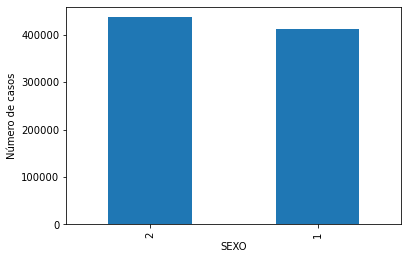

2    436759
1    411623
Name: SEXO, dtype: int64


In [22]:
cpdel = pt_covid19['SEXO'].value_counts().plot(kind='bar') #'1'= mujer, '2'= hombre
plt.xlabel('SEXO')
plt.ylabel('Número de casos')
plt.show()
print(pt_covid19['SEXO'].value_counts())

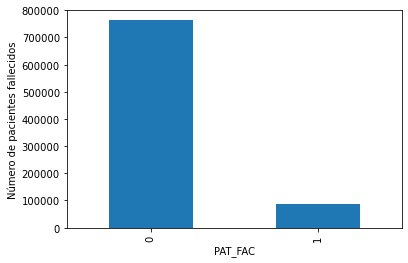

0    762345
1     86037
Name: PAT_FAC, dtype: int64


In [23]:
cpdel = pt_covid19['PAT_FAC'].value_counts().plot(kind='bar')
plt.xlabel('PAT_FAC')
plt.ylabel('Número de pacientes fallecidos')
plt.show()
print(pt_covid19['PAT_FAC'].value_counts())

## Entrenamiento del modelo

In [24]:
def training(X,y,parameters):
    """" Training - fine tuning """
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20,random_state=242)
        
    sample_weights = class_weight.compute_sample_weight('balanced', y_train) #clases desbalanceadas
    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=5, random_state=442)
    parameters=parameters
    estimator = xgb.XGBClassifier()
    grid = GridSearchCV(estimator=estimator, param_grid=parameters, cv = cv, scoring='roc_auc', refit = True)
    model = grid.fit(X_train,y_train,sample_weight = sample_weights)
    return model, X_train, X_test, y_train, y_test

def generating_metrics(model_ehr, x, y):
    """Función para generar las métricas: AUC, sensibilidad, especificidad, F1, precisión"""
    y_pred_proba = model_ehr.predict_proba(x)[:, 1]
    y_pred = model_ehr.predict(x)
    acc = accuracy_score(y,y_pred)
    tn, fp, fn, tp = confusion_matrix(y,y_pred).ravel()
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y, y_pred)
    sensitivity = tp / (tp+fn)
    specificity = tn / (tn+fp)
    auc_score = auc(false_positive_rate, true_positive_rate)
    f1 = f1_score(y, y_pred)
    return auc_score, sensitivity, specificity, f1, acc, false_positive_rate, true_positive_rate

def plot_roc(model,X_test, y_test,name):
    """Función para generar la curva ROC"""
    print("mean_cross_val_score: ", model.best_score_)
    print("best_params:",model.best_params_)
    print("=============================================================================")
    auc_test, sens_test, spec_test, f1_test, acc_test,fpr_test, tpr_test = generating_metrics(model, X_test, y_test)
    print("auc_test: {}, sens_test {}, spec_test: {}, f1_test {}, acc_test {}".format(auc_test, sens_test, spec_test, f1_test, acc_test))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr_test, tpr_test, label='Testing (AUC=%0.2f)' % auc_test, color='darkorange')
    plt.xlabel('1 - Specificity')
    plt.ylabel('Sensitivity')
    plt.legend(loc='best')
    plt.title('Curva ROC del modelo de predicción de mortalidad')
    plt.show()
    name_roc = name+'.png'
    plt.savefig(name_roc)

def plot_shap_values(model,X,feature_list,title):
    """Función para identificar las variables clínicas"""
    explainer = shap.TreeExplainer(model.best_estimator_)
    shap_values = explainer.shap_values(X)
    plt.title(title)
    shap.summary_plot(shap_values, X, feature_names=feature_list, plot_type='bar')
    plt.title(title)
    shap.summary_plot(shap_values, X,feature_names=feature_list,show = 'False')

def saving_model(model,model_name,logs_file):
    """Función para guardar el modelo"""
    import joblib
    model_name = model_name + '.pkl'
    url_save = os.path.join(logs_file,str(model_name))
    print(url_save)
    joblib.dump(model, url_save)

## Predicción de mortalidad basado en comorbilidades, sexo y edad

(848382, 15)
(848382, 1)
Variables usada para entrenar: 
 Index(['SEXO', 'NEUMONIA', 'EDAD', 'EMBARAZO', 'DIABETES', 'EPOC', 'ASMA',
       'INMUSUPR', 'HIPERTENSION', 'OTRA_COM', 'CARDIOVASCULAR', 'OBESIDAD',
       'RENAL_CRONICA', 'TABAQUISMO', 'ND_TRANSCURRIDOS'],
      dtype='object')
mean_cross_val_score:  0.9177214503778041
best_params: {'eval_metric': 'auc', 'learning_rate': 0.3, 'max_depth': 4, 'n_estimators': 100, 'objective': 'binary:logistic', 'reg_alpha': 20, 'reg_lambda': 5}
auc_test: 0.850012640587575, sens_test 0.8750729713952131, spec_test: 0.8249523097799367, f1_test 0.5096645869812828, acc_test 0.8300123175209368


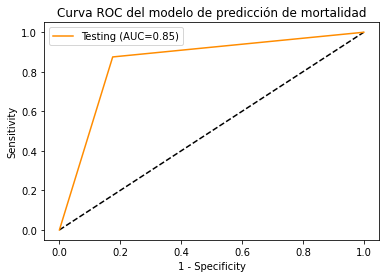

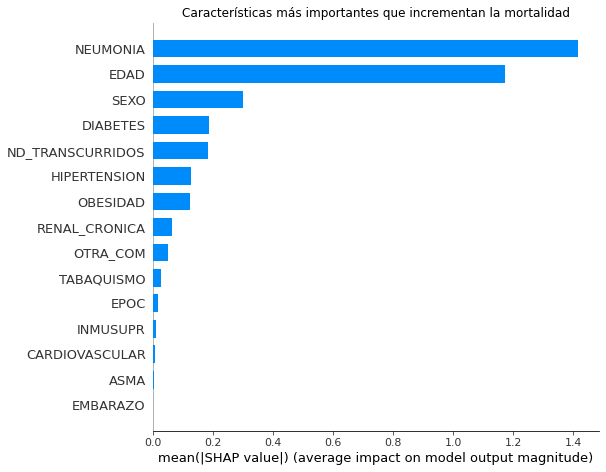

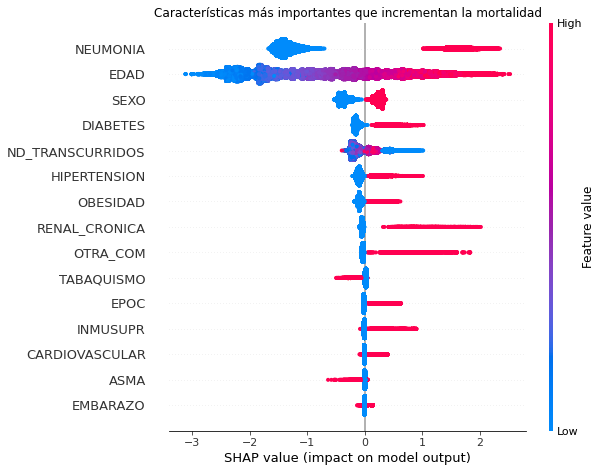

../models/model.pkl


In [25]:
"""Training data: comorbilidades + edad + sexo"""

X = pt_covid19.drop(['FECHA_ACTUALIZACION', 'ID_REGISTRO',                       
                         #demográficos
                          'NACIONALIDAD','HABLA_LENGUA_INDIG', 'INDIGENA',
                          'MIGRANTE', 'PAIS_NACIONALIDAD', 'PAIS_ORIGEN',
                        #datos hospitalarios
                           'ORIGEN', 'SECTOR','FECHA_INGRESO', 'FECHA_SINTOMAS', 'FECHA_DEF', 
                           'INTUBADO', 'TIPO_PACIENTE','UCI','PAT_COVID',
                        #referentes a prueba covid
                           'TOMA_MUESTRA', 'RESULTADO_LAB', 'CLASIFICACION_FINAL',
                         #comorbilidades
                           'OTRO_CASO',
                        #entidades
                           'ENTIDAD_UM','ENTIDAD_NAC', 'ENTIDAD_RES', 'MUNICIPIO_RES', 
                           'AGUASCALIENTES','BAJA_CALIFORNIA','BAJA_CALIFORNIA_SUR', 
                           'CAMPECHE', 'COAHUILA', 'COLIMA', 'CHIAPAS','CHIHUAHUA', 
                           'CDMX', 'DURANGO', 'GUANAJUATO', 'GUERRERO', 'HIDALGO',
                           'JALISCO', 'EDO_MEXICO', 'MICHOACAN', 'MORELOS', 'NAYARIT',
                           'NUEVO_LEON', 'OAXACA', 'PUEBLA', 'QUERETARO', 'QUINTANA_ROO',
                           'SAN_LUIS_POTOSÍ', 'SINALOA', 'SONORA', 'TABASCO', 'TAMAULIPAS',
                           'TLAXCALA', 'VERACRUZ', 'YUCATAN', 'ZACATECAS',
                       #sector   
                           'CRUZ_ROJA', 'DIF','ESTATAL', 'IMSS', 'IMSS_BIENESTAR', 'ISSSTE', 
                           'MUNICIPAL', 'PEMEX','PRIVADA', 'SEDENA', 'SEMAR', 'SSA', 'UNIVERSITARIO', 
                       #origen
                          'USMER','FUERA_USMER',
                        #label:
                           'PAT_FAC'],axis=1)

y = pt_covid19['PAT_FAC'].astype(int)
y = y.values.reshape(y.shape[0],1) #reshape
feature_list = X.columns
print(X.shape)
print(y.shape)

parameters={"n_estimators": [100,200],
            "learning_rate": [0.01, 0.3],
            "reg_alpha" : [20], 
            "reg_lambda": [5],
            "objective": ['binary:logistic'],
            "max_depth": [4,6],
            "eval_metric": ['auc']
            }
model,X_train, X_test, y_train, y_test = training(X,y,parameters)
print("Variables usada para entrenar: \n", X.columns)

plot_roc(model,X_test, y_test,'model')
title = "Características más importantes que incrementan la mortalidad"
plot_shap_values(model,X_test,feature_list,title)
saving_model(model,"model",'../models')

In [26]:
print(feature_list)

Index(['SEXO', 'NEUMONIA', 'EDAD', 'EMBARAZO', 'DIABETES', 'EPOC', 'ASMA',
       'INMUSUPR', 'HIPERTENSION', 'OTRA_COM', 'CARDIOVASCULAR', 'OBESIDAD',
       'RENAL_CRONICA', 'TABAQUISMO', 'ND_TRANSCURRIDOS'],
      dtype='object')


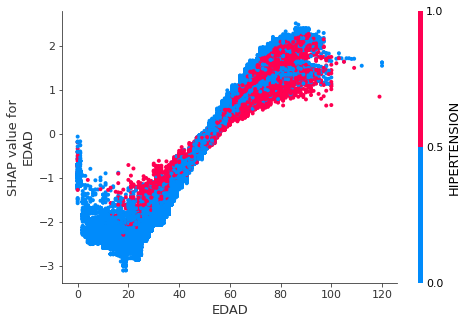

In [27]:
explainer = shap.TreeExplainer(model.best_estimator_)
shap_values = explainer.shap_values(X_test)  
shap.dependence_plot(2, shap_values, X_test, interaction_index=8,feature_names=feature_list)

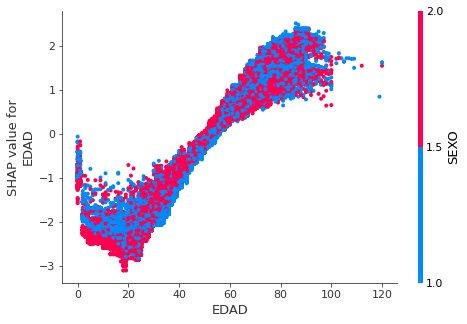

In [28]:
explainer = shap.TreeExplainer(model.best_estimator_)
shap_values = explainer.shap_values(X_test)  
shap.dependence_plot(2, shap_values, X_test, interaction_index=0,feature_names=feature_list)

In [31]:
"""Identificación de marcadores por sexo"""

X_test_mujeres = X_test[(X_test["SEXO"]==1)] #femenino
X_test_hombres = X_test[(X_test["SEXO"]==2)] #masculino

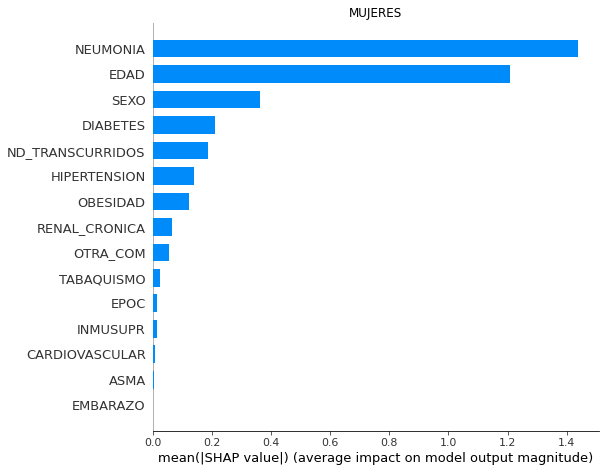

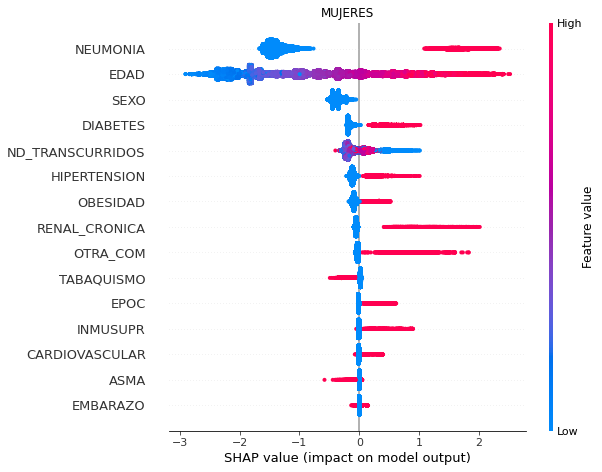

In [32]:
plot_shap_values(model,X_test_mujeres,feature_list,'MUJERES')

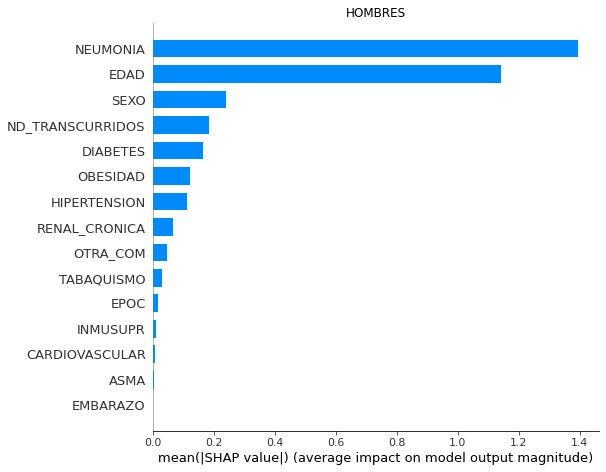

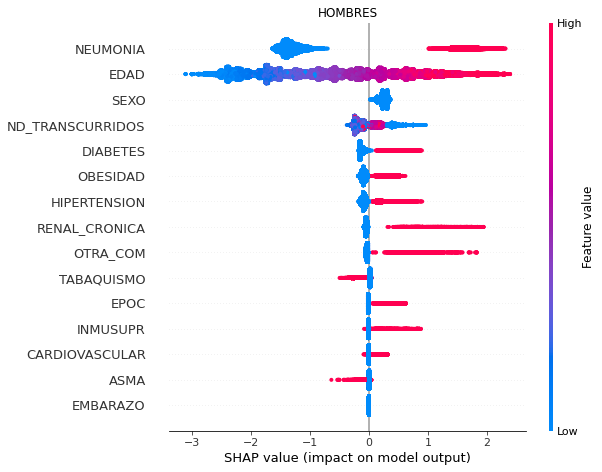

In [33]:
plot_shap_values(model,X_test_hombres,feature_list,'HOMBRES')